# Activity explorer
This piece of code is to explore the function of going through the synthetic population and grabbing an appropriate activity profile for the individual

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from sklearn.mixture import GaussianMixture
import scipy.stats as stats
import sys
sys.path.append('../')  # Add the parent directory to the system path

import tripsender.nhts as nhts

## Load and clean data

In [2]:
# Read data
nhts_data = pd.read_csv('../data/raw/NHTS/Data_RVU_2017_GBG_utanEXTRA.csv', sep=';')

# Preprocess data
df = nhts.preprocess_data(nhts_data,unique_trips_only = False)

c:\Users\ssanjay\AppData\Local\Continuum\anaconda3\envs\tripsender\lib\site-packages\IPython\core\interactiveshell.py:3266: DtypeWarning: Columns (34,41,42,43) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
def fit_and_plot(purpose, start_times):
    plt.figure(figsize=(15, 5))
    
    distributions = distribution_mapping.get(purpose)
    if distributions is None:
        print(f"No distribution found for purpose: {purpose}")
        return

    x = np.linspace(0, 24, 500)  # for 24 hours, assuming the start_times are in hours
    
    min_ssd = np.inf  # Initialize it here
    best_fit_name = None
    best_params = None

    if distributions[0] == 'bimodal':
        gmm = GaussianMixture(n_components=2)
        gmm.fit(start_times.reshape(-1, 1))
        y = np.exp(gmm.score_samples(x.reshape(-1, 1)))
        best_fit_name = 'bimodal'
        best_params = gmm.weights_, gmm.means_, gmm.covariances_
    
    elif distributions[0] == 'trimodal':
        gmm = GaussianMixture(n_components=3)
        gmm.fit(start_times.reshape(-1, 1))
        y = np.exp(gmm.score_samples(x.reshape(-1, 1)))
        best_fit_name = 'trimodal'
        best_params = gmm.weights_, gmm.means_, gmm.covariances_
    else:
        best_y = None
        samples = None

        for dist_name in distributions:
            dist = getattr(stats, dist_name)
            params = dist.fit(start_times)
            y_fitted = dist.pdf(x, *params[:-2], loc=params[-2], scale=params[-1])

            

            # Plot KDE and get its values
            kde = sns.kdeplot(start_times, bw_adjust=1, cut=0)
            x_kde = kde.get_lines()[0].get_xdata()
            y_kde = kde.get_lines()[0].get_ydata()

            # Interpolate y_fitted at x_kde
            interpolator = interp1d(x, y_fitted, kind='linear', fill_value="extrapolate")
            y_interpolated = interpolator(x_kde)

            ssd = np.sum((y_interpolated - y_kde)**2)

            if ssd < min_ssd:
                best_y = y_fitted
                best_fit_name = dist_name
                min_ssd = ssd
                best_params = params
                samples = dist.rvs(*params[:-2], loc=params[-2], scale=params[-1], size=len(start_times))
        y = best_y

    # Save the best distribution and its parameters to the dictionary
    fitted_distributions[purpose] = {
        'distribution': best_fit_name,
        'parameters': best_params
    }

    plt.clf()
    sns.kdeplot(start_times, bw_adjust=1, color='blue', fill=True, label='KDE of Original Data')
    
    
    if distributions[0] in ['bimodal', 'trimodal']:
        generated_samples = gmm.sample(len(start_times))[0]
        # Kde plot of generated samples
        sns.kdeplot(generated_samples[:, 0], bw_adjust=1, color='red', fill=True, label='KDE of Generated Data')
        # Histogram plot of generated samples
        #sns.histplot(generated_samples[:, 0], bins=24, color='red', alpha=0.2, label='Histogram of Generated Data', kde=True)
        # Histogram plot of original samples
        #sns.histplot(start_times, bins=24, color='blue', alpha=0.2, label='Histogram of Original Data', kde=True)

    else:
        # Kde plot of generated samples
        sns.kdeplot(samples, bw_adjust=1, color='red', fill=True, label='KDE of Generated Data')
        # Histogram plot of generated samples
        #sns.histplot(samples, bins=24, color='red', alpha=0.2, label='Histogram of Generated Data', kde=True)
        # Histogram plot of original samples
        #sns.histplot(start_times, bins=24, color='blue', alpha=0.2, label='Histogram of Original Data', kde=True)
    plt.legend()
    plt.title(f'Purpose: {purpose} | Best Fit: {best_fit_name} | SSD: {min_ssd:.2f} | Start Time Distribution of Activity')
    plt.xlabel('Start Time')
    plt.ylabel('Density')
    plt.show()


def plot_activity_frequency(df, purpose_column, time_column):
    """
    Plot the activity frequency per hour of the day for each unique purpose.

    Parameters:
        df (DataFrame): The input DataFrame.
        purpose_column (str): The column name containing activity purposes.
        time_column (str): The column name containing time data.

    Returns:
        None
    """
    # Get unique purposes from the DataFrame
    purposes = df[purpose_column].unique()

    # Generate a color palette based on the number of purposes
    colors = sns.color_palette("husl", len(purposes))

    for i, purpose in enumerate(purposes):
        # Filter the DataFrame for the current purpose and reset the index
        df_purpose = df[df[purpose_column] == purpose].reset_index(drop=True)

        # Create a new figure with a specified size
        plt.figure(figsize=(15, 5))

        # Select a color from the palette for the current purpose
        color = colors[i]

        # Create a histogram plot of the hour of the day
        sns.histplot(df_purpose[time_column].dt.hour, kde=True, bins=24, color=color)

        # Calculate the number of samples for the current purpose
        n = len(df_purpose)

        # Set the plot title, labels, and display the plot
        plt.title(f'Frequency of activity: {purpose} per hour of the day. Number of samples: {n}')
        plt.xlabel('Hour of the day')
        plt.ylabel('Frequency')
        plt.show()

# Departure time for activities

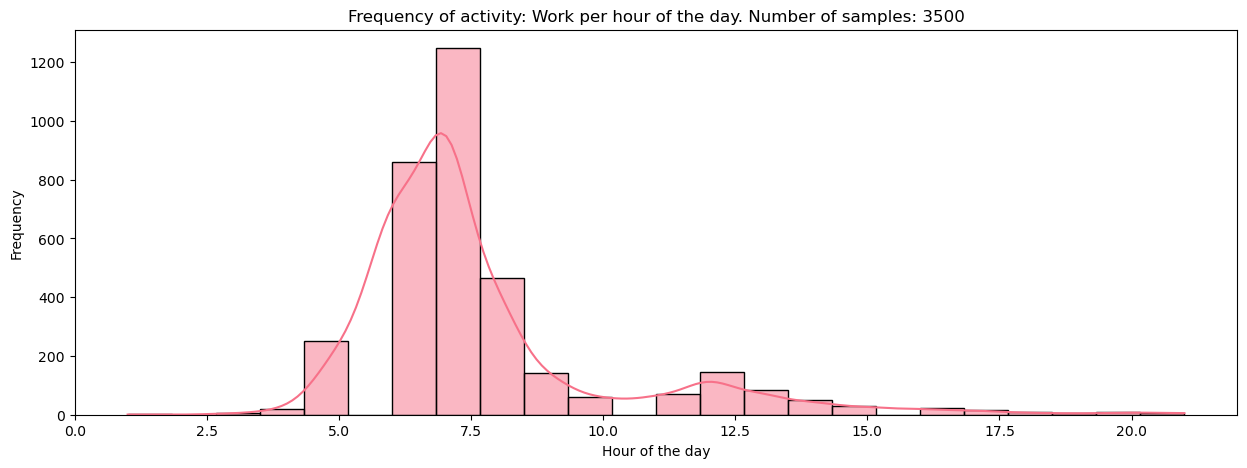

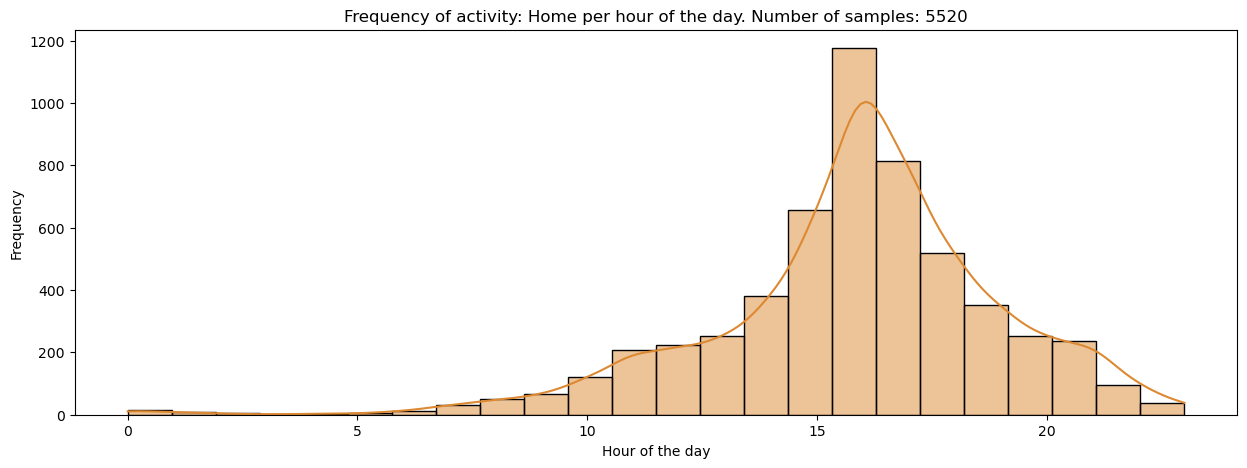

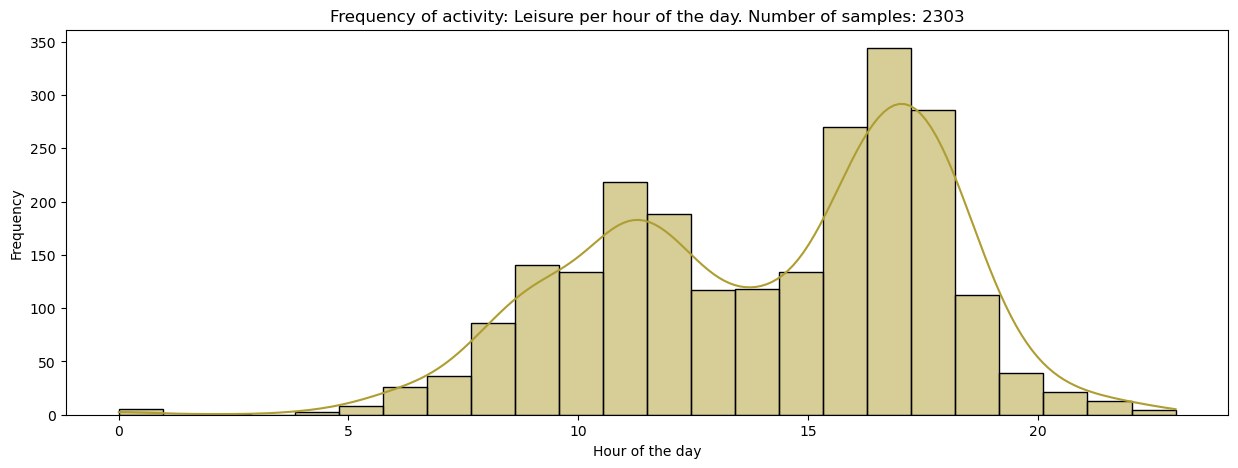

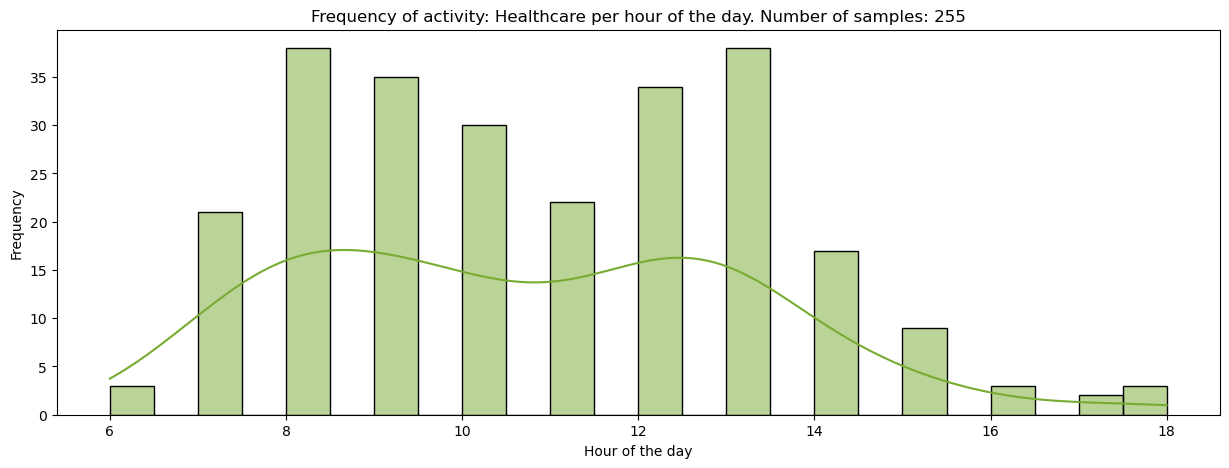

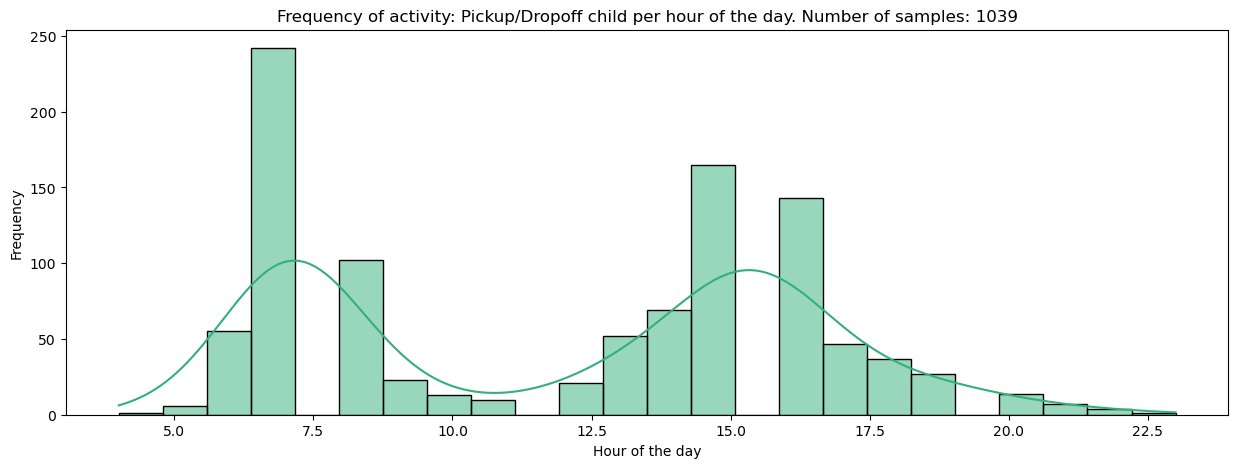

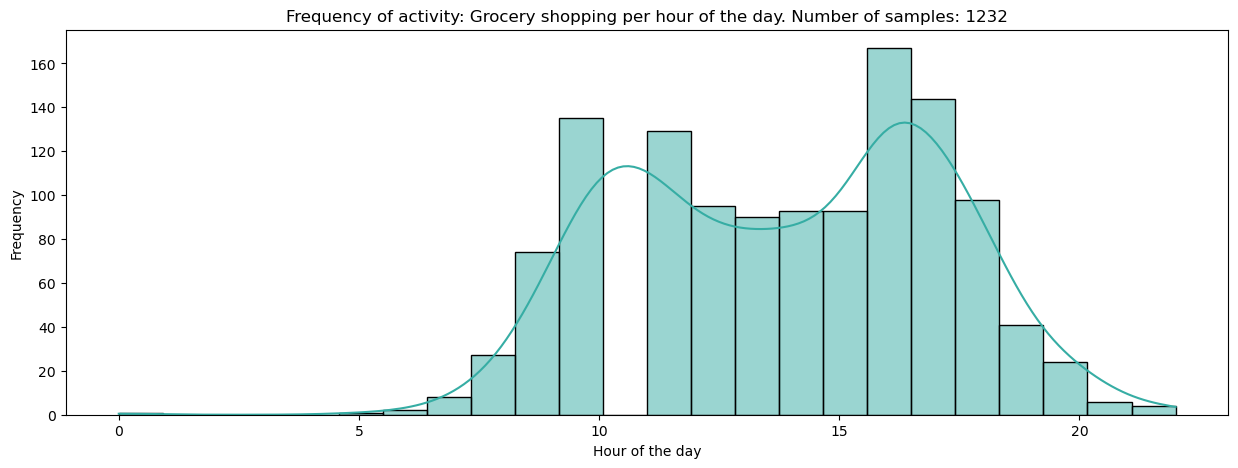

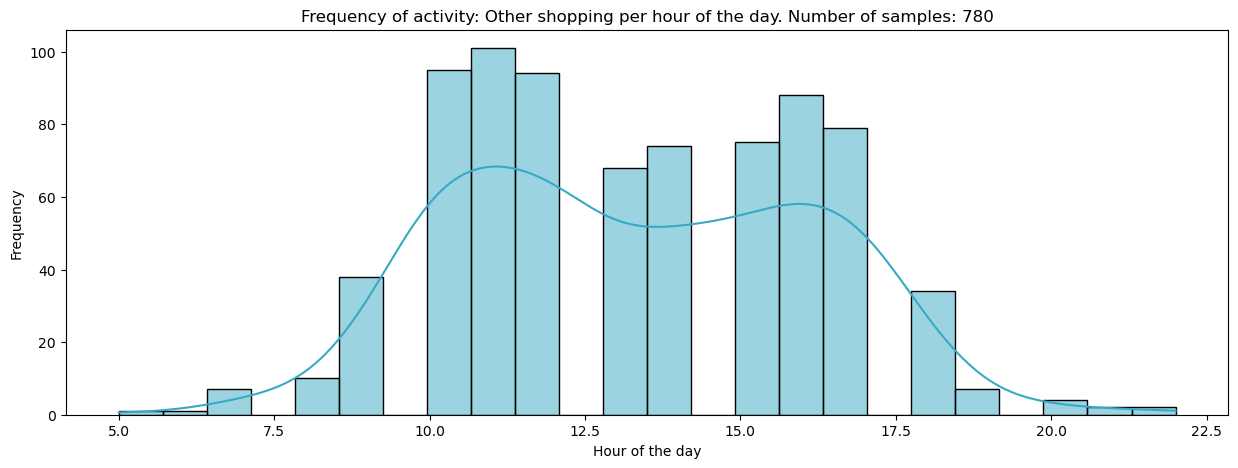

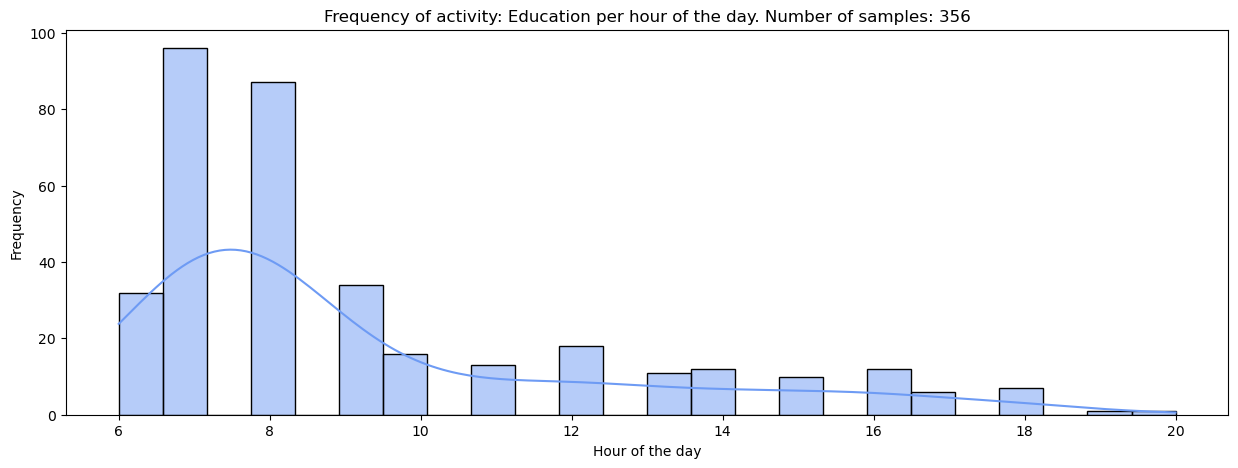

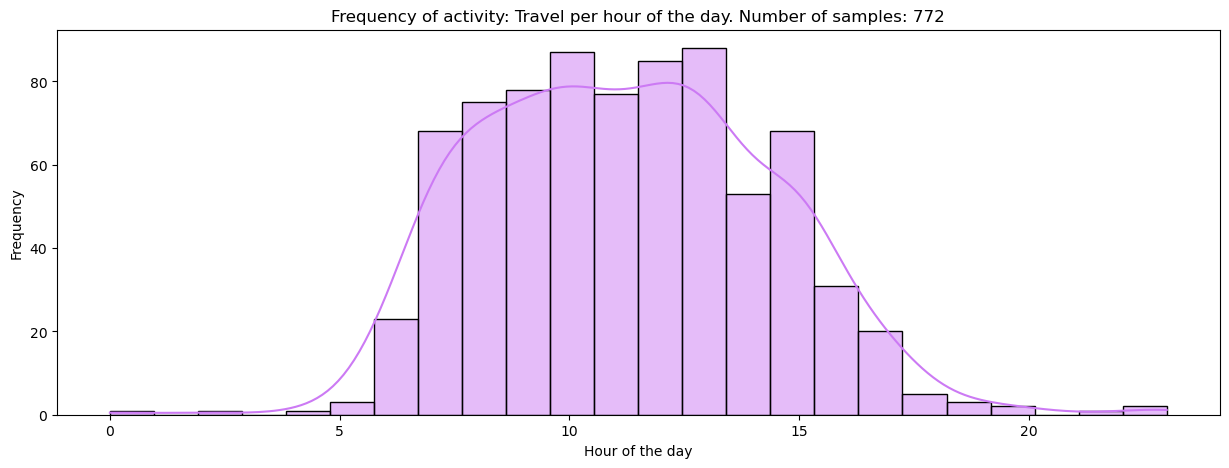

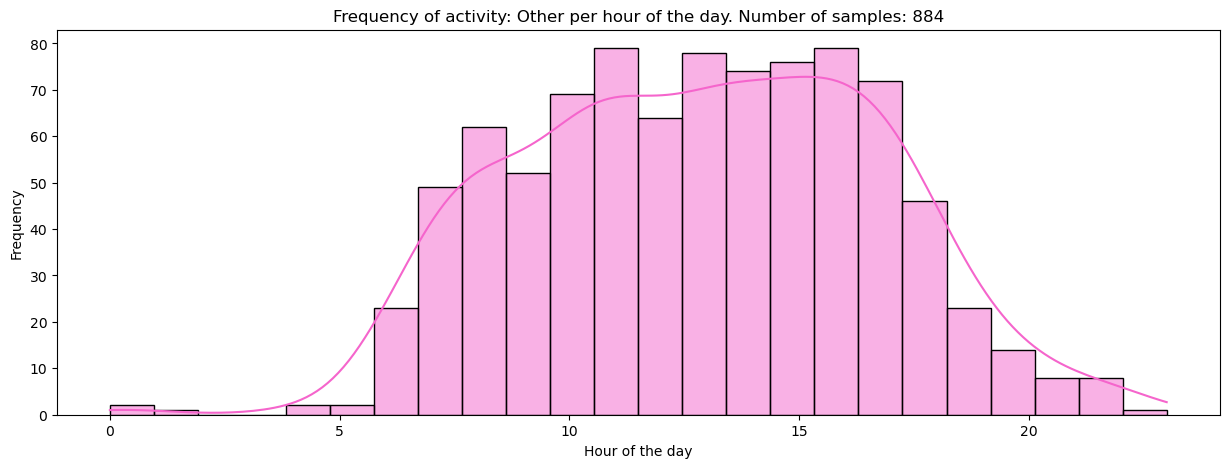

In [4]:
plot_activity_frequency(df, 'purpose', 'start_time')


# Fitting distributions to start times

In [5]:
distribution_mapping =  {
    'Work': ['bimodal'],
    'Leisure': ['bimodal'],
    'Healthcare': ['bimodal'],
    'Grocery shopping': ['bimodal'],
    'Other shopping': ['bimodal'],
    'Education': ['t', 'lognorm', 'weibull_min'],
    'Travel': ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"],
    'Other': ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]}

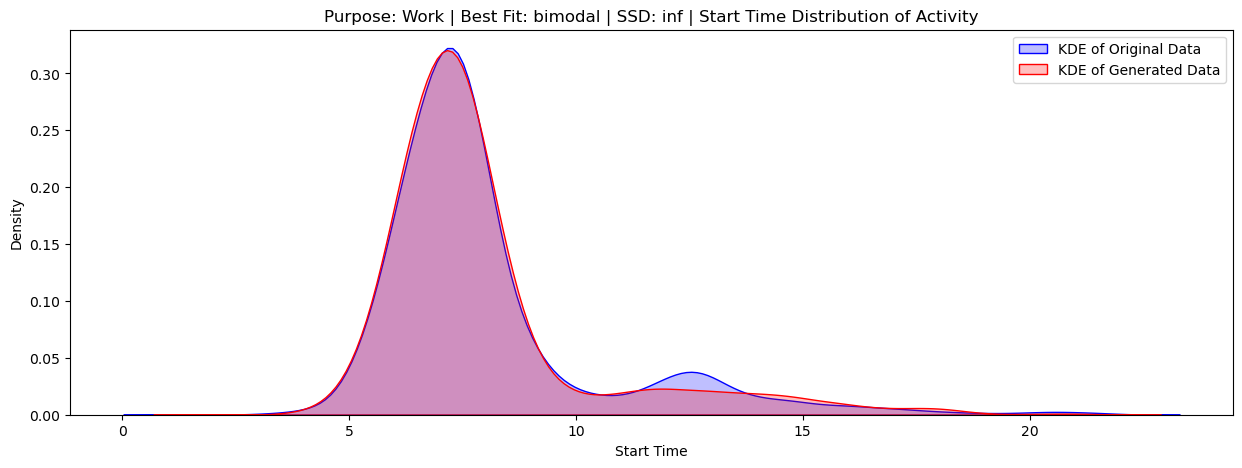

No distribution found for purpose: Home


<Figure size 1500x500 with 0 Axes>

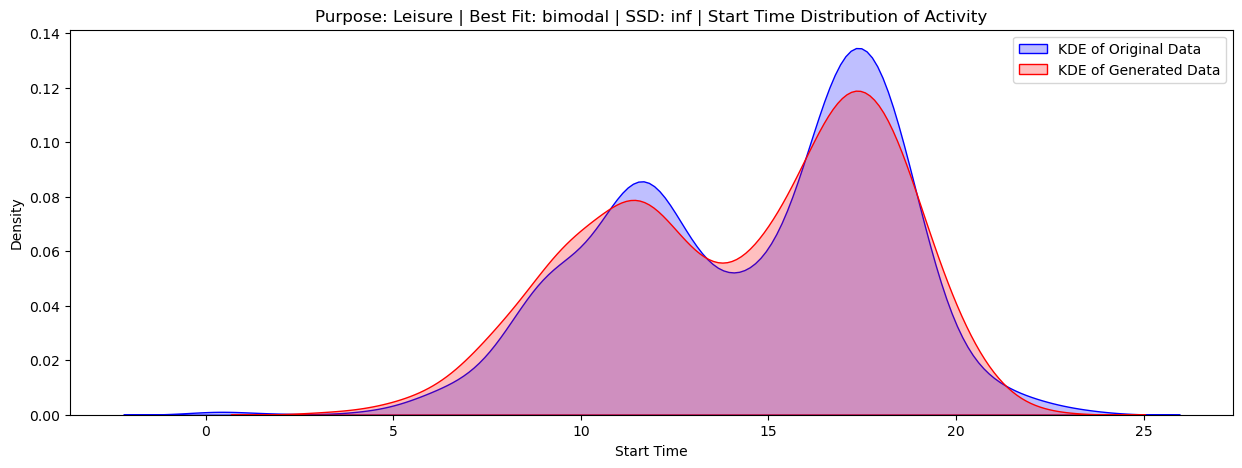

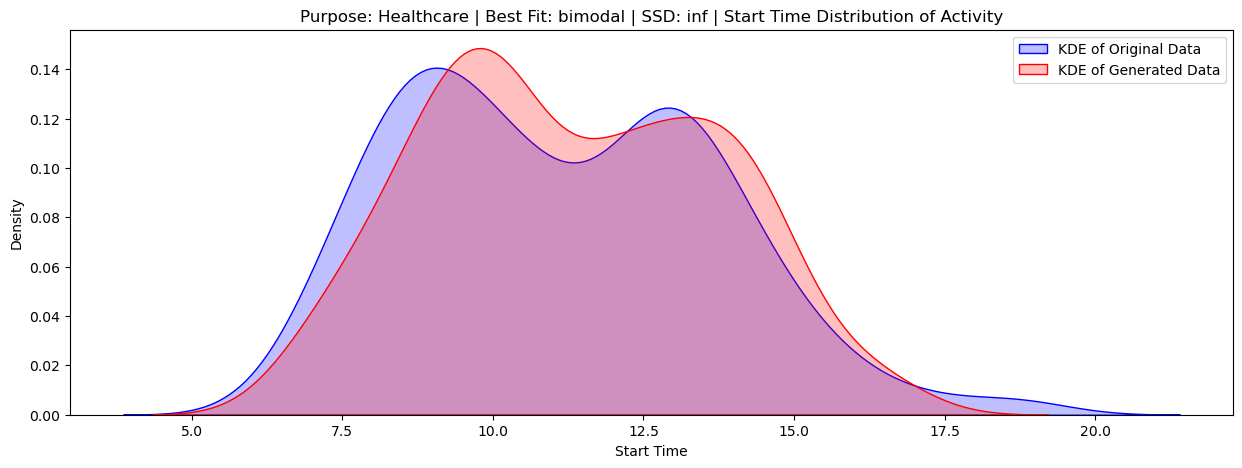

No distribution found for purpose: Pickup/Dropoff child


<Figure size 1500x500 with 0 Axes>

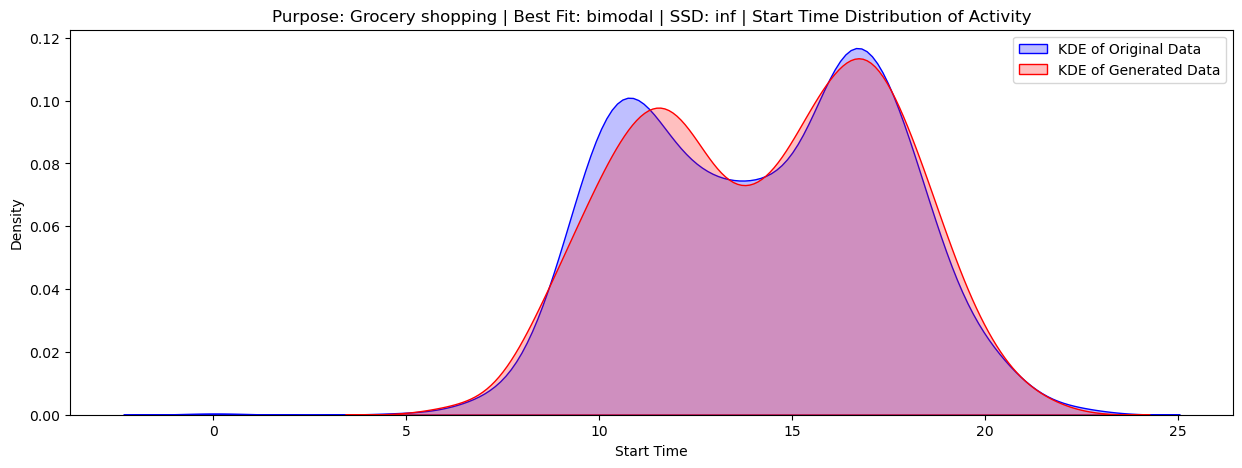

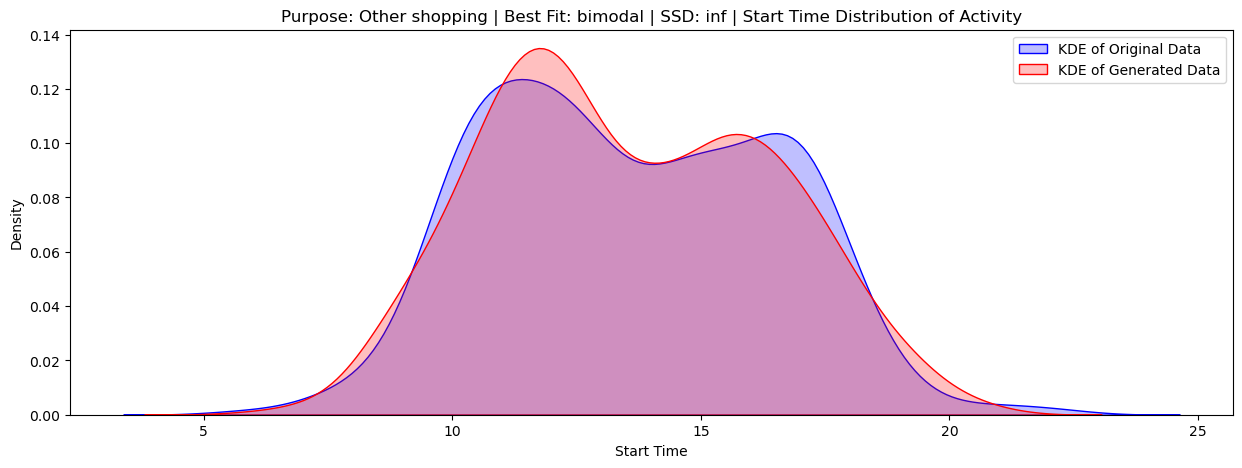

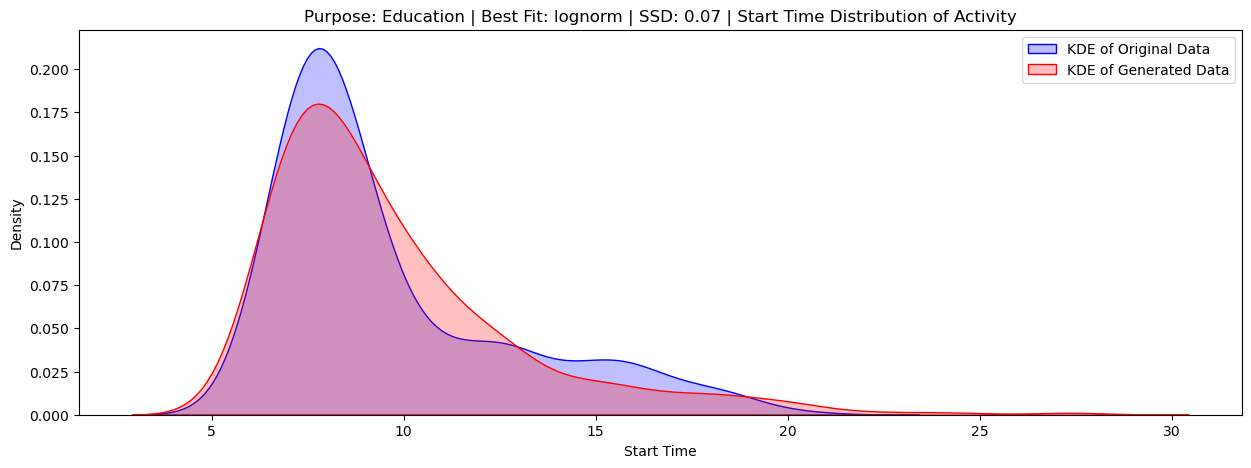

C:\Users\ssanjay\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


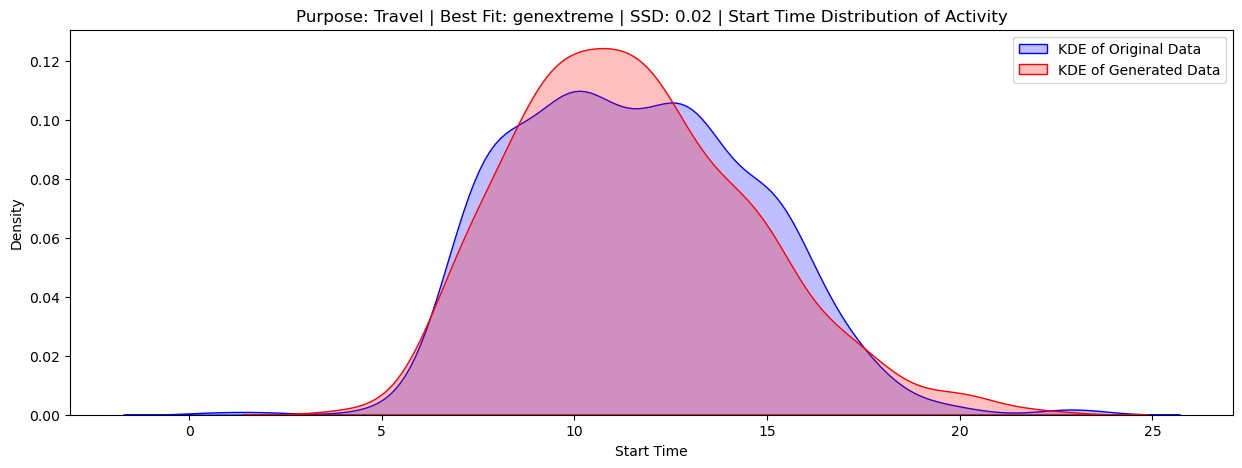

C:\Users\ssanjay\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


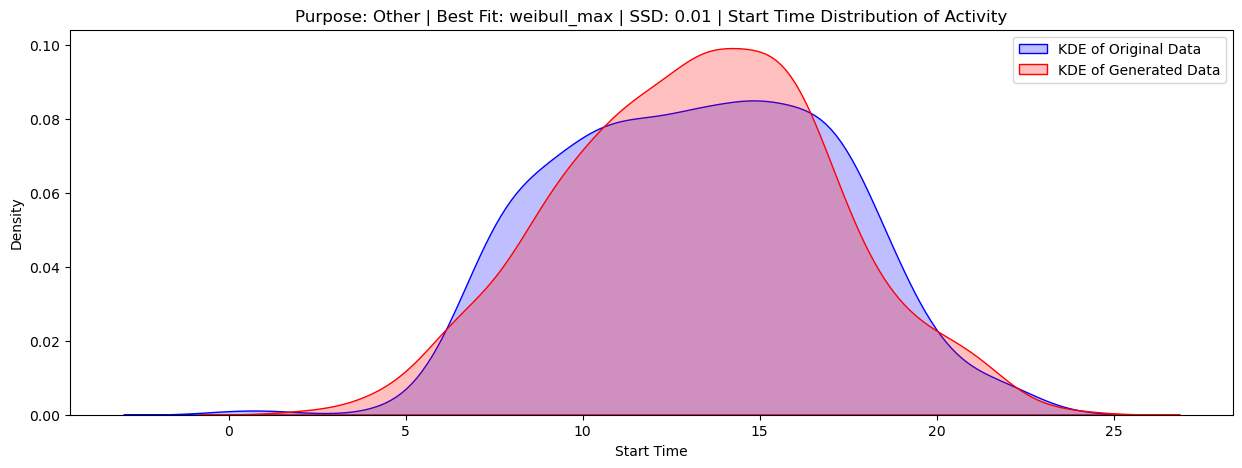

In [6]:
fitted_distributions = {}

# Loop through each unique purpose in the dataframe
for purpose in df['purpose'].unique():
    
    # Extract the start times in float format
    hours = df[df['purpose'] == purpose]['start_time'].dt.hour
    minutes_fraction = df[df['purpose'] == purpose]['start_time'].dt.minute / 60
    start_times_float = hours + minutes_fraction    
    # Fit and plot the start times using the provided function
    fit_and_plot(purpose, start_times_float.values)


In [7]:
# Rename the columns using a dictionary
name_remap = {
    'Work': 'WORK',
    'Leisure': 'LEISURE',
    'Healthcare': 'HEALTHCARE',
    'Grocery shopping': 'GROCERY',
    'Other shopping': 'SHOPPING',
    'Education': 'EDUCATION',
    'Travel': 'TRAVEL',
    'Other': 'OTHER'
}

# Apply the remapping to params_dict
fitted_distributions_renamed = {}
for purpose, params in fitted_distributions.items():
    fitted_distributions_renamed[name_remap[purpose]] = params

In [8]:
import json
import numpy as np

# Custom encoder for NumPy data types
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8, np.int16, np.int32, np.int64, 
                            np.uint8, np.uint16, np.uint32, np.uint64)):
            return int(obj)
        if isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)
        return json.JSONEncoder.default(self, obj)

# Save fitted_distributions to a json file using the custom encoder
with open('../models/START_TIME_DIST.json', 'w') as f:
    json.dump(fitted_distributions_renamed, f, cls=NumpyEncoder, indent=4)


In [9]:
def convert_to_hours_minutes(value):
    hours = int(value)
    minutes = round((value - hours) * 60)
    
    # Adjust for minutes >= 60
    if minutes >= 60:
        hours += 1
        minutes -= 60
    
    return hours, minutes

def post_adjustments(value, sample_type):
    hours, minutes = convert_to_hours_minutes(value)

    if sample_type == 'start_time':
        return "{:02d}{:02d}".format(hours, minutes)
    elif sample_type == 'duration':
        total_minutes = hours * 60 + minutes
        return max(30, total_minutes)
    else:
        raise ValueError(f"Invalid sample_type: {sample_type}")

def sample_from_distribution(distribution, parameters, sample_type='start_time'):
    if distribution not in DISTRIBUTION_FUNCTIONS:
        raise ValueError(f"Unsupported distribution type: {distribution}")
    value = DISTRIBUTION_FUNCTIONS[distribution](parameters)
    return post_adjustments(value, sample_type)

In [10]:
import json
START_TIME_DIST = json.load(open("../models/START_TIME_DIST.json"))
DURATION_DIST = json.load(open("../models/START_TIME_DIST.json"))
def sample_normal(parameters, num_samples=1):
    probs = parameters[0]
    means = parameters[1]
    std_devs = parameters[2]

    chosen_dists = np.random.choice(len(probs), size=num_samples, p=probs)
    samples = [np.random.normal(means[chosen][0], std_devs[chosen][0][0]) for chosen in chosen_dists]
    
    return np.array(samples)

DISTRIBUTION_FUNCTIONS = {
    "trimodal": sample_normal,
    "bimodal": sample_normal,
    "gamma": lambda params, num_samples=1: gamma.rvs(*params, size=num_samples),
    "invgauss": lambda params, num_samples=1: invgauss.rvs(*params, size=num_samples),
    "genextreme": lambda params, num_samples=1: genextreme.rvs(*params, size=num_samples),
    "lognorm": lambda params, num_samples=1: lognorm.rvs(*params, size=num_samples)
}

In [11]:
def sample_duration(purpose, num_samples=1):
    """
    Samples a duration based on the provided purpose and number of samples.

    Parameters:
        purpose (str): The activity purpose.
        num_samples (int): Number of samples to generate. Default is 1.

    Returns:
        ndarray: Generated samples.
    """
    # Check if the purpose exists in the DURATION_DIST
    if purpose not in DURATION_DIST:
        print(f"No distribution found for purpose: {purpose}")
        return None

    # Extract distribution type and its parameters from the DURATION_DIST
    distribution_type = DURATION_DIST[purpose]['distribution']
    params = DURATION_DIST[purpose]['parameters']

    # Check if the distribution type exists in the DISTRIBUTION_FUNCTIONS
    if distribution_type not in DISTRIBUTION_FUNCTIONS:
        print(f"Unsupported distribution type: {distribution_type}")
        return None

    # Generate the samples using the appropriate distribution function
    samples = DISTRIBUTION_FUNCTIONS[distribution_type](params, num_samples)

    return samples

# Example usage:
samples = sample_duration("WORK", 10)
print(samples)


[ 8.0348529   6.61807415  4.44020348  7.31214161  7.00712137  6.75856075
  7.00814076 12.13173977 -2.5803482   7.09871415]
